In [66]:
import os
import warnings
import argparse
import datetime
import pathlib
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import pickle
import torchvision
from test import test
from utils.evaluate_uncertainty import evaluate_uncertainty
from core.config import create_config, save_config
# from core.dataset import COCODataset
from core.dataset_hotswapped import COCODataset
from core.model import Model
from core.metrics import AccuracyLogger
import pickle
from SupContrast.losses import SupConLoss
import torch.nn.functional as F
## Initialization

from torchvision import transforms

from torchvision import datasets

from tqdm import tqdm
from IPython.display import clear_output
import copy

augment_transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
            transforms.RandomGrayscale(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

BATCH_SIZE = 15

train_data = datasets.ImageFolder('../DomainBed/domainbed/data/DGMaterials/main_xml_50/', transform = augment_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=0)

NUM_CLASSES = len(train_data.classes)

In [67]:
criterion = torch.nn.CrossEntropyLoss()

use_gpu = True

import matplotlib.pyplot as plt

%matplotlib inline

In [68]:
def train_model(model, criterion, optimizer, num_epochs=20):
    best_model = model
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0
        
        losses = []
        # Iterate over data.
        iterations = 0
        for data in tqdm(train_loader):
            iterations += 1
            if iterations < 100:
                inputs, labels = data
                inputs = inputs.cuda()
                labels = labels.cuda()

                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                losses.append(loss.item())
                clear_output()
                plt.plot(range(len(losses)), losses)
                plt.title('Accuracy: %s'%best_acc)
                plt.show()
                running_corrects += torch.sum(preds == labels.data)
            else:
                break

        epoch_loss = running_loss
        epoch_acc = running_corrects.item() / float(len(train_loader))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model)
    return best_model


In [69]:
from torchvision import models
from torch import optim

In [70]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc= nn.Linear(num_ftrs, NUM_CLASSES)

In [71]:
criterion.cuda()
model_ft.cuda()

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.00001)

model_ft.train();

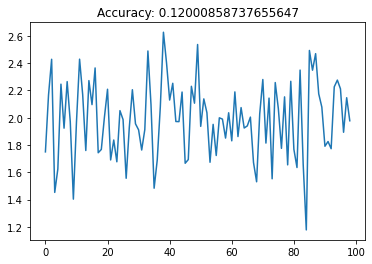

  2%|▏         | 99/4658 [00:43<33:16,  2.28it/s]


In [72]:
# Run the functions and save the best model in the function model_ft.
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=20)

In [19]:
for data in train_loader:
    break